 # README
 
 This notebook is a part of the reproducibility repository for the paper "Cohort-level analysis of human de novo mutations points to drivers of clonal expansion in spermatogonia." The notebook implements some of the key  visualizations reported in the manuscript, including:
 1. Statistical tests for the homogeneity of de novo mutation sampling across cohorts
 2. Enrichment and recurrence analyses of loss-of-function and gain-of-function variants
 3. Investigation of the "winner's curse" effect
 4. Plots of observed versus expected LoF counts
 5. Relationship between gene constraint (LOEUF) and mutation burden. 
 6. CES effects of LoF-2 genes across cohorts

# Dependencies

The following Python libraries are required for this notebook:

- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical computations.
- `seaborn`: For statistical data visualization.
- `gzip`: For handling compressed files.
- `scipy.optimize`: For optimization routines.
- `scipy.special`: For special mathematical functions like `gammaln`.
- `scipy.stats`: For implementations of distributions like multinomial, Negative Binomial, and Poisson.
- `matplotlib.pyplot`: For creating plots and visualizations.

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import gzip
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import multinomial, nbinom, poisson, gamma
import matplotlib.pyplot as plt

In [132]:
### Required files ###
# The list of files presented here is available online along with the code

# Table containing Gene IDs and their corresponding ENSEMBL IDs
ENS2Gene_file = "ENS_ID2Gene_ID.txt.gz"

# Table containing counts of de novo variants published in Kaplanis et al., 2020 stratified by three cohorts: DDD, GeneDx and RUMC
DNW_per_cohort_LoF_cnt_file = "DNW_denovo_counts.txt.gz"

# Table containing results of de novo LoF enrichment analysis on the NDD cohort from Kaplanis et al., 2020 and 
#   the ASD cohort from Zhou et al., 2022
ASD_NDD_LoF_enrich_file = "ASD_NDD_LoF_enrich_file.txt"

# Table containing the number of de novo missense variants in the NDD cohort from Kaplanis et al., 2020
NDD_missense_recurrence_file = "NDD_missense_recurrence.txt.gz"

# Winner's curse table
winners_curse_file = "winners_curse.csv"

# File containing the observed and expected counts of LoF variants in gnomAD
gnomAD_LoF_counts_file = "LOE_gnomAD.txt"

# Table with results of the LoF enrichment analysis for the NDD cohort from Kaplanis et al., 2020 abd ASD cohort from Zhou et al., 2022
ASD_NDD_file = "ASD_NDD_LoF_results.txt"

# File containing the results of the LoF enrichment analysis for the control cohort
CNTRL_file = "CNTRL_LoF_results.txt"

# File containing the results of the LoF enrichment analysis for the  encephalopathic epilepsy (EE) cohort
EE_file = "EE_LoF_results.txt"

# File containing the results of the LoF enrichment analysis for the congenital heart disease (CHD) cohort
CHD_file = "CHD_LoF_results.txt"

# Lists of CES genes in LoF-1 and LoF-2 sets
CE_LoF_ENS_1 = [
    'ENSG00000176165', 'ENSG00000157540', 'ENSG00000168036', 
    'ENSG00000185129', 'ENSG00000049618'
]

CE_LoF_ENS_2 = [
    'ENSG00000064419', 'ENSG00000101752', 'ENSG00000111262', 
    'ENSG00000115758', 'ENSG00000117139', 'ENSG00000119772', 
    'ENSG00000134440', 'ENSG00000136158', 'ENSG00000137834', 
    'ENSG00000141376', 'ENSG00000145907', 'ENSG00000146830', 
    'ENSG00000148737', 'ENSG00000157933', 'ENSG00000170836', 
    'ENSG00000171456', 'ENSG00000171862', 'ENSG00000196712', 
    'ENSG00000256463'
]

<h2>1. Homogeneity of sampling</h2>
Here, we test whether the sample of <i>de novo</i> mutations in NDD cases published by Kaplanis et al. is homogenous across three cohorts comprising the joint cohort. We assume the samples to be taken homogeniously if the probability of inclusion of a loss-of-function variant does not depend on the cohort across all genes. At the level of cohorts, this would mean that the fractions of <i>de novo</i> variants across the genes are proportional to the cohort sizes conditional on mean parental ages, which are approximated by the counts of synonymous <i>de novo</i> variants per each cohort.<br>
Thus, for every gene and under homogeneity, the counts of variants given by each cohort should follow Multinomial distribution with probabilities proportional to the counts of synonymous <i>de novo</i> variants in respective cohort.<br>
Four models are tested in the framework of Akaike information criterion (ensuring minimal punishment for additional parameters in the model):<br>
1. Multinomial distribution with probabilities given by the counts of synonymous variants.<br>
2. Multinomial distribution with probabilities inferred using a likelihood-maximization procedure.<br>
3. Dirichlet-Multinomial distribution with fixed mean probabilities and amplitude parameter inferred using a likelihood-maximization procedure.<br>
4. Dirichlet-Multinomial distribution with both the mean probabilities and amplitude parameter inferred using a likelihood-maximization procedure.<br>
<br>
The likelihoods are then compared and the model with the lowest Akaike factor is chosen. If the first model is chosen over the three alternatives, the sample is deemed homogeneous

In [ ]:
######## Alternative model 1 ########
# Fixed P, multinomial noise, 0 params
def multinom_fixed_p(N_vec, p_vec):
    """
    N_vec: list of lists, each list contains counts of de novo variants from each cohort
    p_vec: list of [unnormalized] multinomial probabilities
    """
    N_vec = np.array(N_vec)
    N_vec = N_vec.T
    p_vec = np.array(p_vec)/np.sum(p_vec)
    n = N_vec.sum(axis=1)
    nll = np.sum(-np.log(multinomial.pmf(N_vec, n, p_vec)))
    return nll, p_vec

######## Alternative model 2 ########
# Random P, multinomial noise, 2 free params
def multinom_random_p(N_vec, p_vec_init):
    """
    N_vec: list of lists, each list contains counts of de novo variants from each cohort
    p_vec_init: initial values of probabilities for optimization
    """
    N_vec = np.array(N_vec)
    N_vec = N_vec.T
    p_vec_init = np.array(p_vec_init)/np.sum(p_vec_init)
    p_vec_init = p_vec_init[:-1]
    n = N_vec.sum(axis=1)

    def multinom_nll(p_vec, data):
        """
        p_vec: list of [unnormalized] multinomial probabilities
        data: counts of de novo variants from each cohort
        """
        p_vec = np.append(p_vec, 1.0 - np.sum(p_vec))
        N_vec = data
        n = N_vec.sum(axis=1)
        pmf_values = multinomial.pmf(N_vec, n, p_vec)
        nll = -np.sum(np.log(pmf_values))
        return nll
    
    res = minimize(multinom_nll, 
                   p_vec_init, 
                   args=(N_vec,), 
                   method='L-BFGS-B', 
                   bounds=[(1e-3, 1-1e-3)]*len(p_vec_init)) # Bounds are chosen to avoid numerical issues
    p_vec = res.x
    nll_est = multinom_nll(p_vec, N_vec)
    return nll_est, p_vec


# PDF of Dirichlet-Multinomial distribution
def DirMultPDF(N_vec, alpha_vec):
    """
    N_vec: list of counts of de novo variants from each cohort
    alpha_vec: list of parameters of Dirichlet distribution
    """
    N_vec = np.array(N_vec)
    alpha_vec = np.array(alpha_vec)
    alpha = np.sum(alpha_vec)
    N = np.sum(N_vec)

    return gammaln(alpha) + gammaln(N + 1) - gammaln(N + alpha) +\
           np.sum(gammaln(N_vec + alpha_vec) - gammaln(alpha_vec) - gammaln(N_vec + 1))
 
######## Alternative model 3 ########
# Fixed mean P, DirMult noise, 1 free param (amplitude of Dirichlet)
def DirMult_fixedP(N_vec, p_vec, alpha_init=5):
    """
    N_vec: list of lists, each list contains counts of de novo variants from each cohort
    p_vec: list of [unnormalized] multinomial probabilities
    alpha_init: initial value of Dirichlet parameter
    """
    N_vec = np.array(N_vec)
    N_vec = N_vec.T
    p_vec = np.array(p_vec)/np.sum(p_vec)
    #n = N_vec.sum(axis=1)

    def DirMult_nll(alpha, data):
        
        alpha_vec = p_vec*alpha
        N_vec = data
        n = N_vec.sum(axis=1)
        pmf_values = [DirMultPDF(N_vec[i], alpha_vec) for i in range
                      (len(N_vec))]
        nll = -np.sum(pmf_values)
        return nll
    
    res = minimize(DirMult_nll, 
                   [alpha_init], 
                   args=(N_vec,), 
                   method='L-BFGS-B', 
                   bounds=[(1.0, 1e8)])
    p_s = res.x
    nll_est = DirMult_nll(p_s, N_vec)
    return nll_est, p_s

######## Alternative model 4 ########
# Random mean P, DirMult noise, 3 free params (parameters of Dirichlet)
def DirMult_randomP(N_vec, p_vec_init, alpha_init=5.0):
    """
    N_vec: list of lists, each list contains counts of de novo variants from each cohort
    p_vec_init: initial values of probabilities for optimization
    alpha_init: initial value of Dirichlet parameter for optimization
    """
    N_vec = np.array(N_vec)
    N_vec = N_vec.T
    p_vec_init = np.array(p_vec_init)/np.sum(p_vec_init)
    alpha_vec_init = alpha_init * p_vec_init

    def DirMult_nll(alpha_vec, data):
        N_vec = data
        pmf_values = [DirMultPDF(N_vec[i], alpha_vec) for i in range
                      (len(N_vec))]
        nll = -np.sum(pmf_values)
        return nll
    
    res = minimize(DirMult_nll, 
                   alpha_vec_init, 
                   args=(N_vec,), 
                   method='L-BFGS-B', 
                   bounds=[(1, None)]*len(p_vec_init))
    p_vec = res.x
    nll_est = DirMult_nll(p_vec, N_vec)
    return nll_est, p_vec

def compute_aic(nll, k):
    """
    Compute Akaike Information Criterion (AIC).
    nll: Negative log-likelihood of the model.
    k: Number of free parameters in the model.
    """
    return 2 * k + 2 * nll

# Print results for a given gene list
def print_res(df_cnt, P_vec):
    N_vec = [df_cnt["DDD_N"], df_cnt["GDX_N"], df_cnt["RUMC_N"]]

    ### Compute the negative log-likelihood and Akaike Information Criterion (AIC) for each model
    # Model 1: Fixed P, multinomial noise
    nLL, _ = multinom_fixed_p(N_vec, P_vec)
    AIC_multinom_fixed_p = compute_aic(nLL, 0)
    print(f"Model 1 | fixed p\tnLL={nLL}\tAkaike={AIC_multinom_fixed_p}")

    # Model 2: Random P, multinomial noise
    nLL, _ = multinom_random_p(N_vec, P_vec)
    AIC_multinom_random_p = compute_aic(nLL, 2)
    print(f"Model 2 | random p\tnLL={nLL}\tAkaike={AIC_multinom_random_p}")

    # Model 3: DirMult fixed p
    nLL, _ = DirMult_fixedP(N_vec, P_vec)
    AIC_DirMult_fixed_p = compute_aic(nLL, 1)
    print(f"Model 3 | DirMult fixed p\tnLL={nLL}\tAkaike={AIC_DirMult_fixed_p}")

    # Model 4: DirMult random p
    nLL, _ = DirMult_randomP(N_vec, P_vec)
    AIC_DirMult_random_p = compute_aic(nLL, 3)
    print(f"Model 4 | DirMult random p\tnLL={nLL}\tAkaike={AIC_DirMult_random_p}")

In [ ]:
# Load the de novo variant counts per cohort
df_cnt = pd.read_csv(gzip.open(DNW_per_cohort_LoF_cnt_file, 'rt'), sep='\t')

# Define vectors containing ENSEMBL IDs of LoF1/2 genes
# LoF-1 genes
CE_LoF_ENS_LoF1 = [
    'ENSG00000176165', 'ENSG00000157540', 'ENSG00000168036', 
    'ENSG00000049618', 'ENSG00000185129'
]

# LoF-2 genes
CE_LoF_ENS_LoF2 = [
    'ENSG00000064419', 'ENSG00000101752', 'ENSG00000111262', 
    'ENSG00000115758', 'ENSG00000117139', 'ENSG00000119772', 
    'ENSG00000134440', 'ENSG00000136158', 'ENSG00000141376', 
    'ENSG00000145907', 'ENSG00000148737', 'ENSG00000170836', 
    'ENSG00000171456', 'ENSG00000171862', 'ENSG00000196712'
]

# Define the total number of synonymous de novo variants in each cohort
P_vec = [
    2821,  # DDD cohort
    5046,  # GeneDx cohort
    643    # RUMC cohort
]

# Combine LoF-1 and LoF-2 genes into a single list
CE_LoF_ENS_LoF = CE_LoF_ENS_LoF1 + CE_LoF_ENS_LoF2

# Analyze non-CES genes
print("Non-CES genes")
df_cnt2 = df_cnt[~df_cnt["CE"]]  # Filter genes not in CES
print_res(df_cnt2, P_vec)

# Analyze LoF-1 genes
print("\nLoF-1 genes")
df_cnt_lof1 = df_cnt[df_cnt["ENS_ID"].isin(CE_LoF_ENS_LoF1)]  # Filter LoF-1 genes
print_res(df_cnt_lof1, P_vec)

# Analyze LoF-2 genes
print("\nLoF-2 genes")
df_cnt_lof2 = df_cnt[df_cnt["ENS_ID"].isin(CE_LoF_ENS_LoF2)]  # Filter LoF-2 genes
print_res(df_cnt_lof2, P_vec)

# Analyze all LoF genes
print("\nAll LoF genes")
df_cnt_lof2 = df_cnt[df_cnt["ENS_ID"].isin(CE_LoF_ENS_LoF)]  # Filter all LoF genes
print_res(df_cnt_lof2, P_vec)


Non-CES genes
Model 1 | fixed p	nLL=1659.047655282309	Akaike=3318.095310564618
Model 2 | random p	nLL=1657.3013850583143	Akaike=3318.6027701166286
Model 3 | DirMult fixed p	nLL=1658.455502711984	Akaike=3318.911005423968
Model 4 | DirMult random p	nLL=1657.2394448127518	Akaike=3320.4788896255036

LoF-1 genes
Model 1 | fixed p	nLL=19.762410183312596	Akaike=39.52482036662519
Model 2 | random p	nLL=17.96444021638578	Akaike=39.92888043277156
Model 3 | DirMult fixed p	nLL=19.790950711309065	Akaike=41.58190142261813
Model 4 | DirMult random p	nLL=18.104214358497345	Akaike=42.20842871699469

LoF-2 genes
Model 1 | fixed p	nLL=32.35456073324252	Akaike=64.70912146648504
Model 2 | random p	nLL=32.35456073324252	Akaike=68.70912146648504
Model 3 | DirMult fixed p	nLL=32.36312635938198	Akaike=66.72625271876396
Model 4 | DirMult random p	nLL=31.751804517668496	Akaike=69.50360903533699

All LoF genes
Model 1 | fixed p	nLL=52.116970916555125	Akaike=104.23394183311025
Model 2 | random p	nLL=51.6399712394

/var/folders/lp/tg73n10s4nz06fzkwth8fm440000gp/T/ipykernel_1806/1608203061.py:33: RuntimeWarning: divide by zero encountered in log
  nll = -np.sum(np.log(pmf_values))


<h2>2. Magnitudes of effects</h2>

Code for making plots used to showcase some basic properties of the de novo NDD dataset such as:<br>

1. The scatter plot of observed vs. expected counts of <i>de novo</i> LoF variants in the NDD cohort.<br>
2. Histograms of per-gene LoF recurrence
3. Histogram of per-position missense recurrence

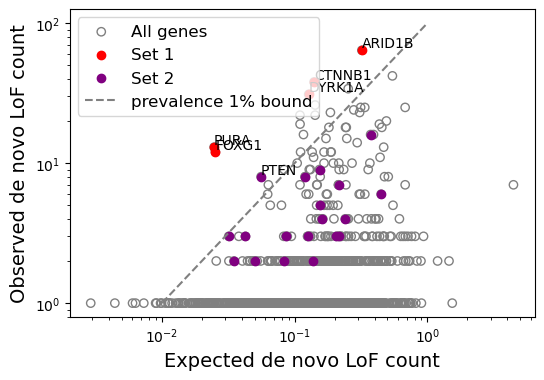

In [112]:
# First, the per-gene LoF effects
# Load the Ensembl-to-GeneID table

df_ens2gene = pd.read_csv(gzip.open(ENS2Gene_file, 'rt'), sep='\t', header=None)
ENS2GeneID_dict = {row[0]: row[1] for row in df_ens2gene.values}

df_cnt = pd.read_csv(gzip.open(DNW_per_cohort_LoF_cnt_file, 'rt'), sep='\t')
df_cnt["total_cnt"] = df_cnt["DDD_N"] + df_cnt["GDX_N"] + df_cnt["RUMC_N"]
df_cnt["GeneID"] = df_cnt["ENS_ID"].map(ENS2GeneID_dict)

# Subsample the dataframes
df_cnt_set1 = df_cnt[df_cnt["ENS_ID"].isin(CE_LoF_ENS_1)]
df_cnt_set2 = df_cnt[df_cnt["ENS_ID"].isin(CE_LoF_ENS_2)]


plt.gcf().set_size_inches(6, 4)

# Replot the points with new marker styles
plt.scatter(df_cnt["total_lambda"], df_cnt["total_cnt"], facecolors='none', edgecolors='grey', label='All genes')
plt.scatter(df_cnt_set1["total_lambda"], df_cnt_set1["total_cnt"], color='red', label='Set 1')
plt.scatter(df_cnt_set2["total_lambda"], df_cnt_set2["total_cnt"], color='purple', label='Set 2')

# Add gene labels for points in set 1 above the line (y = 100*x)
for _, row in df_cnt_set1.iterrows():
    if row['total_cnt'] > 100 * row['total_lambda']:
        plt.text(row['total_lambda'], row['total_cnt'], row['GeneID'], fontsize=10, ha='left', va='bottom')

# Add gene labels for points in set 2 above the line (y = 100*x)
for _, row in df_cnt_set2.iterrows():
    if row['total_cnt'] > 100 * row['total_lambda']:
        plt.text(row['total_lambda'], row['total_cnt'], row['GeneID'], fontsize=10, ha='left', va='bottom')

plt.plot([0.01, 1], [1, 100], color="grey", linestyle='--', label="prevalence 1% bound")
plt.legend(fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Observed de novo LoF count", fontsize=14)
plt.xlabel("Expected de novo LoF count", fontsize=14)
plt.savefig("LoF_count_scatter.pdf")
plt.show()

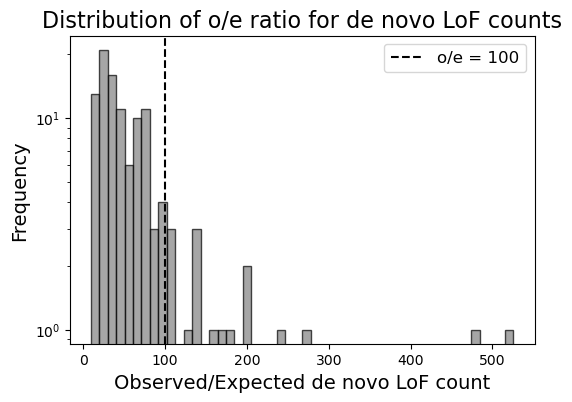

In [84]:
# o/e ratio from the previous plot, but this time as just a histogram

# restrict to just the FDR 10% genes
df_cnt_FDR10 = df_cnt[df_cnt["FDR10_sig"]]

plt.figure(figsize=(6, 4))
plt.hist(df_cnt_FDR10["total_cnt"] / df_cnt_FDR10["total_lambda"], bins=50, color='grey', edgecolor='black', alpha=0.7)

# Vertical line at x=100
plt.axvline(x=100, color='black', linestyle='--', label='o/e = 100')
plt.xlabel("Observed/Expected de novo LoF count", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of o/e ratio for de novo LoF counts", fontsize=16)
plt.yscale("log")
plt.legend(fontsize=12)
plt.savefig("LoF_count_histogram.pdf")
plt.show()

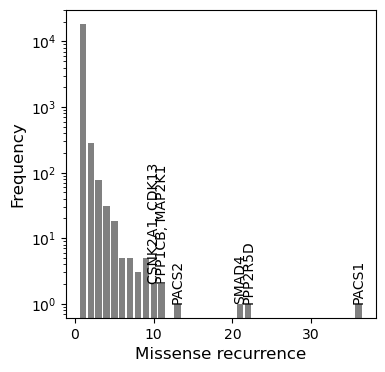

In [66]:
# Second, the per-variant missense recurrence

df = pd.read_csv(gzip.open(NDD_missense_recurrence_file, 'rt'), sep='\t')

vals, counts = np.unique(df["n_vars"], return_counts=True)
vals = vals[vals >= 1]
counts = counts[-len(vals):]

plt.figure(figsize=(4, 4))

# Create the bar plot with grey bars
plt.bar(vals, counts, color='grey')

# Set x-axis and y-axis labels
plt.xlabel("Missense recurrence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add gene identities at the tops of bars for x >= 10
for val, count in zip(vals, counts):
    if val >= 10:
        gene_ids = df[df["n_vars"] == val]["GeneID"].tolist()
        plt.text(val, count, ', '.join(gene_ids), fontsize=10, ha='center', va='bottom', rotation=90)

plt.yscale("log")
plt.savefig("missense_count_barplot.pdf")
plt.show()


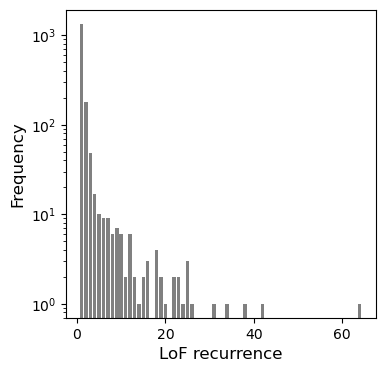

In [67]:
# Third, the per-gene LoF recurrence

vals, counts = np.unique(df_cnt["total_cnt"], return_counts=True)

plt.figure(figsize=(4, 4))
# Create the bar plot with grey bars
plt.bar(vals, counts, color='grey')
# Set x-axis and y-axis labels
plt.xlabel("LoF recurrence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.yscale("log")
plt.savefig("LoF_count_barplot.pdf")
plt.show()


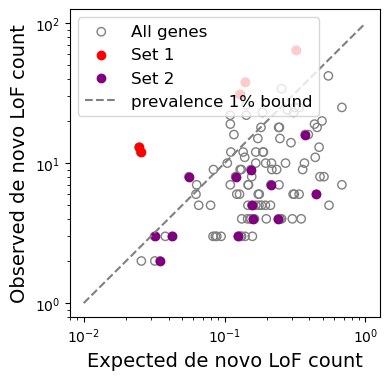

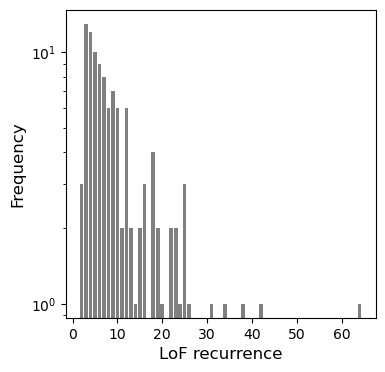

In [ ]:
# Fourth, the previous two plots but just for FDR 10% significant genes

# Calculate Poisson probabilities and add them as a column
df_cnt["Pois_P"] = poisson.sf(df_cnt["total_cnt"] - 1, df_cnt["total_lambda"])

# Define critical FDR and total number of genes
crit_FDR = 0.1
L = 17730

# Sort dataframe by Poisson probabilities
df_cnt = df_cnt.sort_values(by="Pois_P", ascending=True)

# Calculate FDR and identify significant genes
df_cnt["FDR"] = df_cnt["Pois_P"] * L / np.arange(1, len(df_cnt) + 1)
df_cnt["FDR10_sig"] = df_cnt["FDR"] < crit_FDR

# Filter genes with FDR < 10%
df_FDR10 = df_cnt[df_cnt["FDR10_sig"]].reset_index(drop=True)

# SCATTER PLOT
# Subsample the dataframes for specific gene sets
df_cnt_set1 = df_FDR10[df_FDR10["ENS_ID"].isin(CE_LoF_ENS_1)]
df_cnt_set2 = df_FDR10[df_FDR10["ENS_ID"].isin(CE_LoF_ENS_2)]

# Set plot size
plt.gcf().set_size_inches(4, 4)

# Plot scatter points for all genes and specific gene sets
plt.scatter(df_FDR10["total_lambda"], df_FDR10["total_cnt"], facecolors='none', edgecolors='grey', label='All genes')
plt.scatter(df_cnt_set1["total_lambda"], df_cnt_set1["total_cnt"], color='red', label='Set 1')
plt.scatter(df_cnt_set2["total_lambda"], df_cnt_set2["total_cnt"], color='purple', label='Set 2')

# Add prevalence bound line and legend
plt.plot([0.01, 1], [1, 100], color="grey", linestyle='--', label="prevalence 1% bound")
plt.legend(fontsize=12)

# Set axis scales and labels
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Observed de novo LoF count", fontsize=14)
plt.xlabel("Expected de novo LoF count", fontsize=14)

# Save and display the scatter plot
plt.savefig("LoF_count_scatter_FDR10.pdf")
plt.show()

# HISTOGRAM
# Calculate unique values and their frequencies
vals, counts = np.unique(df_FDR10["total_cnt"], return_counts=True)

# Set plot size
plt.figure(figsize=(4, 4))

# Create histogram with grey bars
plt.bar(vals, counts, color='grey')

# Set axis labels and scale
plt.xlabel("LoF recurrence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.yscale("log")

# Save and display the histogram
plt.savefig("LoF_count_barplot_FDR10.pdf")
plt.show()


<h2>3. Winner's curse effect</h2>

Here, we plot the distribution of fraction of genes in the overlap between two random samples from the NanoSeq dataset

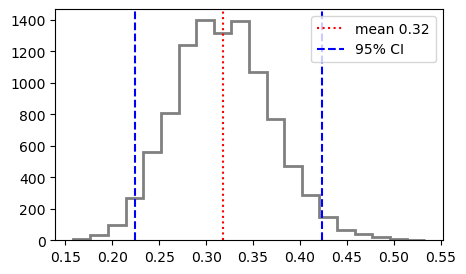

In [ ]:
# File containing the magnitudes of the winner's curse effect
winners_curse_file = "winners_curse.csv"

df_vc = pd.read_csv(winners_curse_file)

# Create a histogram of the data
plt.figure(figsize=(5, 3))
plt.hist(df_vc['x'], bins=20, histtype="step", color="grey", linewidth=2)

# Add a vertical line at the mean value
mean_x = df_vc['x'].mean()
plt.axvline(mean_x, color='red', linestyle=':', label=f'mean {mean_x:.2f}')

# Calculate the 95% confidence interval (CI) bounds
L = len(df_vc['x'])
bottom_CI = sorted(df_vc['x'])[int(0.025 * L)]  # Lower bound of 95% CI
top_CI = sorted(df_vc['x'])[int(0.975 * L)]     # Upper bound of 95% CI

# Add vertical lines for the 95% CI bounds
plt.axvline(bottom_CI, color='blue', linestyle='--', label='95% CI')
plt.axvline(top_CI, color='blue', linestyle='--')

# Add a legend to the plot
plt.legend()

# Save the plot to a file and display it
plt.savefig("winners_curse.pdf")
plt.show()

<h2>4. Genes associated with ASD/NDD through loss-of-function</h2>
Code for plotting the scatter plot of unscaled penetrance vs. LOEUF values with set 1 and set 2 genes labeled.

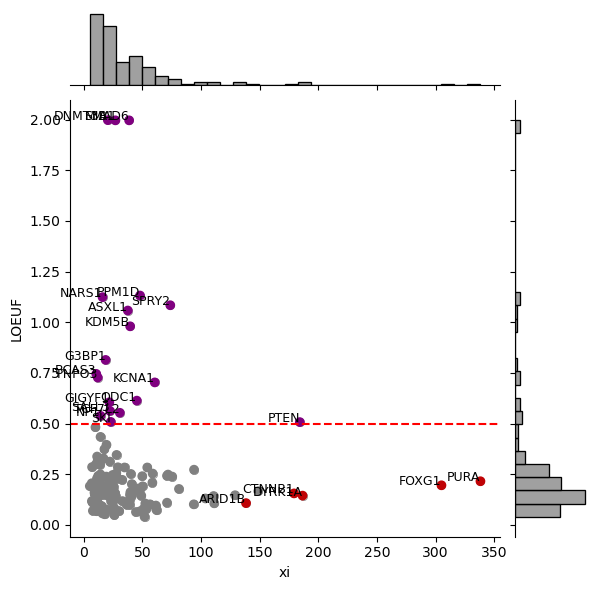

In [118]:
# Load the ASD/NDD LoF enrichment data
df_ASDNDD = pd.read_csv(ASD_NDD_LoF_enrich_file, sep='\t')

# Filter rows where FDR_0.1 is True
df_ASDNDD = df_ASDNDD[df_ASDNDD["FDR_0.1"]]

# Add boolean columns indicating gene categories
df_ASDNDD["CE1_bool"] = df_ASDNDD["ensembl_gene_id"].isin(CE_LoF_ENS_1)  # LoF-1 CES genes
df_ASDNDD["CE2_bool"] = df_ASDNDD["ensembl_gene_id"].isin(CE_LoF_ENS_2)  # LoF-2 CES genes
df_ASDNDD["NCE_bool"] = ~df_ASDNDD["ensembl_gene_id"].isin(np.concatenate((CE_LoF_ENS_1, CE_LoF_ENS_2)))  # Non-CES genes

def plot_LOEUF_scatter(df, LOEUF, output_file='fig2a_raw.pdf', hline_y=0.5):
    """
    Create a scatter plot with marginal distributions for LOEUF values.

    Parameters:
    df (pd.DataFrame): DataFrame containing the data to plot.
    LOEUF (str): Column name for LOEUF values in the dataframe.
    output_file (str): File name to save the plot. Defaults to "fig2a_raw.pdf".
    hline_y (float): Position of the horizontal line. Defaults to 0.5.
    """
    # Assign colors based on gene categories
    colors = np.where(df['NCE_bool'], '#808080',  # Grey for non-CES genes
                      np.where(df['CE1_bool'], '#c00205',  # Red for LoF-1 CES genes
                               np.where(df['CE2_bool'], '#800080', '#000000')))  # Purple for LoF-2 CES genes

    # Create a scatter plot with marginal distributions
    joint_plot = sns.jointplot(
        x='xi',  # x-axis: unscaled penetrance
        y=LOEUF,  # y-axis: LOEUF values
        data=df,
        kind="scatter",
        marginal_kws=dict(bins=30, fill=True),  # Marginal histogram settings
        joint_kws={'facecolors': 'white', 'edgecolors': 'grey', 'marker': 'o'},  # Scatter plot settings
        color='grey'  # Default color for scatter points
    )

    # Add a horizontal line at the specified y position
    joint_plot.ax_joint.axhline(y=hline_y, color='red', linestyle='--')

    # Overlay scatter points with assigned colors
    joint_plot.ax_joint.scatter(df['xi'], df[LOEUF], c=colors)

    # Add text labels for genes in category 1 or category 2 or above the horizontal line
    for i in range(len(df)):
        if df['CE1_bool'][i] or df['CE2_bool'][i] or df[LOEUF][i] > hline_y:
            joint_plot.ax_joint.text(df['xi'][i], df[LOEUF][i], df['gene_name'][i], fontsize=9, ha='right')

    # Save the plot to the specified file and display it
    plt.savefig(output_file)
    plt.show()

# Call the function to create the plot
plot_LOEUF_scatter(df_ASDNDD, "LOEUF", hline_y=0.5)

In [114]:
# Calculate LOE/LOELF

# File containing the observed and expected counts of LoF variants in gnomAD
gnomAD_LoF_counts_file = "LOE_gnomAD.txt"


def calc_LOE_LOELF(obs_count, exp_count):
    """
    Calculate LOE and LOELF from observed and expected LoF counts.
    obs_count: Observed count of LoF variants.
    exp_count: Expected count of LoF variants.

    LOE is defined as the ratio of observed to expected counts.
    LOELF is defined as the 95% lower bound of observed-to-expected counts assuming Poisson 
        distribution of observed counts. Poisson distribution is substituted to its 
        conjugate gamma to estimate the parameter
    """
    if exp_count == 0:
        return np.nan, np.nan  # Avoid division by zero
    LOE = obs_count / exp_count
    LOELF = gamma.ppf(0.05, a=obs_count + 1, scale=1) / exp_count  # 95% lower bound of the parameter of Poisson distribution
    
    # Enforce upper bound of 2 on LOE/LOELF
    LOE = min(LOE, 2.0)
    LOELF = min(LOELF, 2.0)
    
    return LOE, LOELF


df_LOE = pd.read_table(gnomAD_LoF_counts_file, sep=' ', header = None)

# Initialize dictionaries to store LOE and LOELF values
dict_LOE, dict_LOELF = {}, {}

# Calculate LOE and LOELF for each gene
for i, row in df_LOE.iterrows():
    gene_id = row[0]
    obs_count = row[1]
    exp_count = row[2]
    
    LOE, LOELF = calc_LOE_LOELF(obs_count, exp_count)
    
    dict_LOE[gene_id] = LOE
    dict_LOELF[gene_id] = LOELF



In [120]:
# Add LOE and LOELF to the df_ASDNDD DataFrame
df_ASDNDD['LOE'] = df_ASDNDD['ensembl_gene_id'].map(dict_LOE)
df_ASDNDD['LOELF'] = df_ASDNDD['ensembl_gene_id'].map(dict_LOELF)

print(df_ASDNDD[['ensembl_gene_id', 'gene_name', 'LOE', 'LOELF']].head())

   ensembl_gene_id gene_name       LOE     LOELF
0  ENSG00000095787       WAC  0.060128  0.027385
1  ENSG00000156650     KAT6B  0.079887  0.049282
2  ENSG00000171862      PTEN  0.426673  0.233626
3  ENSG00000108001      EBF3  0.189329  0.103668
4  ENSG00000110066     KMT5B  0.111811  0.061222


LOE threshold: 0.3550463307909706
LOELF threshold: 0.23362598196902565

Genes above LOE threshold:
    gene_name       LOE
2        PTEN  0.426673
18      KDM5B  0.715969
48      PPM1D  1.058226
53      ASXL1  1.334653
61       MIB1  2.000000
73     TCF7L2  0.393409
76     GIGYF1  0.511370
86      SPRY2  0.453408
96     DNMT3A  2.000000
97      KCNA1  0.666020
107      ODC1  0.424344
114     G3BP1  0.667414
124     ZMYM2  0.367723
125       SKI  0.457916
126     SMAD6  2.000000
127     NARS1  0.893700
128     SALL3  0.404575
132     TNPO3  0.565110
149     BCAS3  0.500440

Genes above LOELF threshold:
    gene_name     LOELF
18      KDM5B  0.600260
23     SHANK3  0.240275
48      PPM1D  0.835536
53      ASXL1  1.148199
61       MIB1  1.909236
64        NF1  0.284757
73     TCF7L2  0.252096
76     GIGYF1  0.398346
86      SPRY2  0.279708
96     DNMT3A  2.000000
97      KCNA1  0.455804
107      ODC1  0.255804
114     G3BP1  0.465597
124     ZMYM2  0.282848
125       SKI  0.322190
126    

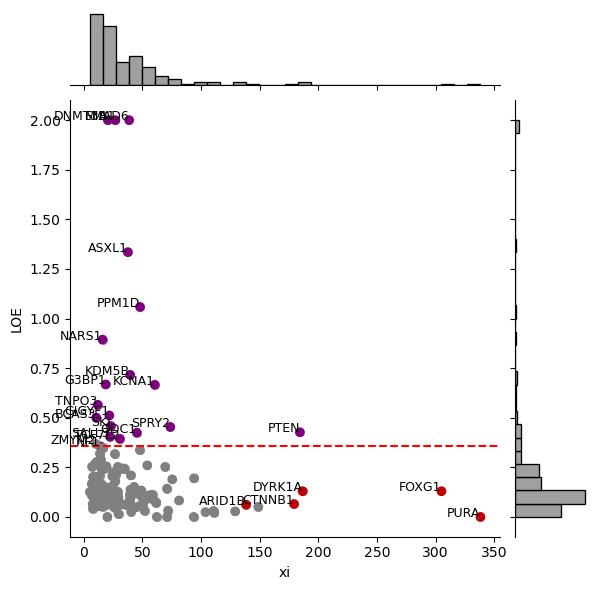

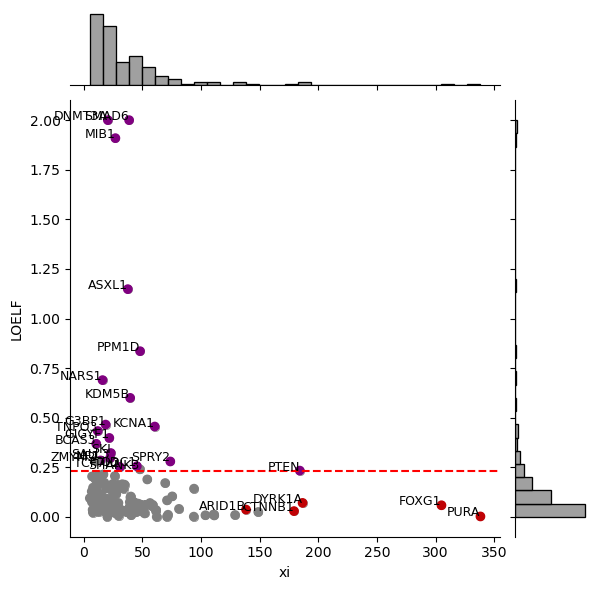

In [124]:
# xi vs. LOE and LOELF scatter plots (call the plotting function for each)

# Infer thresholds for LOE/LOELF as the minimal LOE/LOELF of CE2
LOE_threshold = df_ASDNDD[df_ASDNDD['CE2_bool']]['LOE'].min()
LOELF_threshold = df_ASDNDD[df_ASDNDD['CE2_bool']]['LOELF'].min()

# Print thresholds
print(f"LOE threshold: {LOE_threshold}")
print(f"LOELF threshold: {LOELF_threshold}")

# list the genes above LOE/LOELF thresholds
print("\nGenes above LOE threshold:")
print(df_ASDNDD[df_ASDNDD['LOE'] > LOE_threshold][['gene_name', 'LOE']])
print("\nGenes above LOELF threshold:")
print(df_ASDNDD[df_ASDNDD['LOELF'] > LOELF_threshold][['gene_name', 'LOELF']])

# Plot LOE and LOELF scatter plots
plot_LOEUF_scatter(df_ASDNDD, 'LOE', 'fig2b_LOE.pdf', hline_y=LOE_threshold)
plot_LOEUF_scatter(df_ASDNDD, 'LOELF', 'fig2c_LOELF.pdf', hline_y=LOELF_threshold)

<h2>5. Stability of the LOEUF threshold</h2>

Here, we compute the cumulative ratio of observed to expected control mutations across NDD/ASD-significant genes genes ranked by LOEUF. To assess whether the observed pattern could arise by chance, we perform 10,000 permutations of LOEUF values and compute cumulative control o/e for each. We visualize the observed signal against the permutation-based mean (which is just a constant here) and confidence intervals. This approach helps determine whether the relationship between LOEUF and cumulative control mutation burden is robust and indeed driven by CES effects.

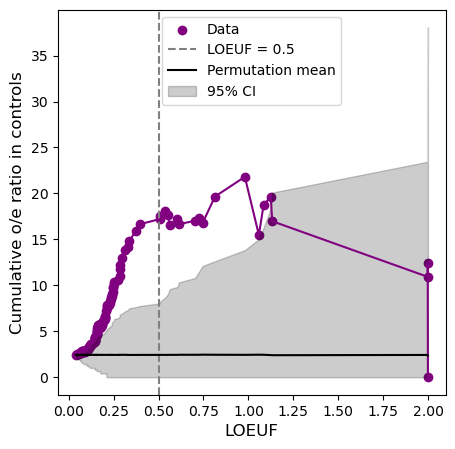

In [130]:
# Cumulative signal vs LOEUF in controls

# File names
ASD_NDD_file = "ASD_NDD_LoF_results.txt"
CNTRL_file = "CNTRL_LoF_results.txt"

# Parameters
crit_FDR = 0.1  # Critical False Discovery Rate
L = 17730  # Total number of genes
crit_FDR = 0.1  # Critical False Discovery Rate
L = 17730  # Total number of genes

# Load and preprocess ASD/NDD data
df_ASD_NDD = pd.read_csv(ASD_NDD_file, sep="\t")
df_ASD_NDD = df_ASD_NDD.sort_values("P_val").reset_index(drop=True)

# Calculate Benjamini-Hochberg critical value and identify significant genes
df_ASD_NDD["BH_critical_value"] = (np.arange(1, len(df_ASD_NDD) + 1) / L) * crit_FDR
df_ASD_NDD["Significant"] = df_ASD_NDD["P_val"] <= df_ASD_NDD["BH_critical_value"]
df_ASD_NDD = df_ASD_NDD[df_ASD_NDD["Significant"]].reset_index(drop=True)

# Load control data and filter for significant genes
df_CNTRL = pd.read_csv(CNTRL_file, sep="\t")
df_CNTRL = df_CNTRL[df_CNTRL["ensembl_gene_id"].isin(df_ASD_NDD["ensembl_gene_id"])].reset_index(drop=True)

# Merge LOEUF values from ASD/NDD data into control data
df_CNTRL = df_CNTRL.merge(df_ASD_NDD[["ensembl_gene_id", "LOEUF"]], on="ensembl_gene_id", how="left")

# Calculate lambda values for controls and ASD/NDD
CNTRL_lambda = np.sum(df_CNTRL["poisson_lambda"])
ASD_NDD_lambda = df_ASD_NDD[df_ASD_NDD["ensembl_gene_id"].isin(df_CNTRL["ensembl_gene_id"])]["poisson_lambda"].sum()
df_ASD_NDD["CNTRL_lambda"] = df_ASD_NDD["poisson_lambda"] * CNTRL_lambda / ASD_NDD_lambda

# Map control counts to ASD/NDD data
CNTRL_vc = dict(zip(df_CNTRL["ensembl_gene_id"], df_CNTRL["count"]))
df_ASD_NDD["control_count"] = df_ASD_NDD["ensembl_gene_id"].map(CNTRL_vc).fillna(0)

# Sort by LOEUF and calculate cumulative ratios
df_ASD_NDD = df_ASD_NDD.sort_values("LOEUF", ascending=False).reset_index(drop=True)
df_ASD_NDD["cumulative_control_count"] = np.cumsum(df_ASD_NDD["control_count"]) / np.cumsum(df_ASD_NDD["CNTRL_lambda"])

# Plot cumulative control count vs LOEUF
plt.figure(figsize=(5, 5))
plt.scatter(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="purple", label="Data")
plt.plot(df_ASD_NDD["LOEUF"], df_ASD_NDD["cumulative_control_count"], color="purple")
plt.axvline(x=0.5, color='grey', linestyle='--', label="LOEUF = 0.5")

# Permute LOEUF values and calculate cumulative ratios for permutations
permut_arrs = []
for _ in range(10000):
    df_ASD_NDD["LOEUF"] = np.random.permutation(df_ASD_NDD["LOEUF"])
    df_ASD_NDD = df_ASD_NDD.sort_values("LOEUF", ascending=False).reset_index(drop=True)
    permut_arrs.append(np.cumsum(df_ASD_NDD["control_count"]) / np.cumsum(df_ASD_NDD["CNTRL_lambda"]))

# Calculate mean and confidence intervals for permutations
permut_arrs = np.array(permut_arrs)
mean_permut_arr = np.mean(permut_arrs, axis=0)
CI_lower_arr = np.percentile(permut_arrs, 0.5, axis=0)
CI_upper_arr = np.percentile(permut_arrs, 99.5, axis=0)

# Add permutation results to the plot
plt.plot(df_ASD_NDD["LOEUF"], mean_permut_arr, color="black", label="Permutation mean")
plt.fill_between(df_ASD_NDD["LOEUF"], CI_lower_arr, CI_upper_arr, color="black", alpha=0.2, label="95% CI")

# Finalize plot
plt.xlabel("LOEUF", fontsize=12)
plt.ylabel("Cumulative o/e ratio in controls", fontsize=12)
plt.legend()
plt.savefig("Cumulative_control_count_vs_LOEUF.pdf")
plt.show()


# 6. CES effects across cohorts

Here, we plot the enrichments of <i>de novo</i> variants in LoF-2 set across cohorts ascertained by different conditions, specifically:

1. ASD/NDD cohort
2. Encephalopathic epilepsy (EE) cohort
3. Congenital heart disease (CHD) cohort
4. Cohort of healthy control trios (CNTRL)

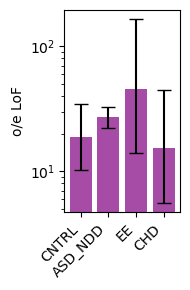

In [ ]:
# File paths for cohort data
CNTRL_file = "CNTRL_LoF_results.txt"
ASD_NDD_file = "ASD_NDD_LoF_results.txt"
EE_file = "EE_LoF_results.txt"
CHD_file = "CHD_LoF_results.txt"

# Blacklist of genes to exclude
blacklist = [
    "ENSG00000119772",  # DNMT3A
    "ENSG00000171456",  # ASXL1
    "ENSG00000170836",  # PPM1D
    "ENSG00000115758"   # ODC1
]

# List of genes in LoF-2 CES set
CE_LoF_ENS_2 = [
    "ENSG00000064419", "ENSG00000101752", "ENSG00000111262", 
    "ENSG00000115758", "ENSG00000117139", "ENSG00000119772", 
    "ENSG00000134440", "ENSG00000136158", "ENSG00000137834", 
    "ENSG00000141376", "ENSG00000145907", "ENSG00000146830", 
    "ENSG00000148737", "ENSG00000157933", "ENSG00000170836", 
    "ENSG00000171456", "ENSG00000171862", "ENSG00000196712", 
    "ENSG00000256463"
]

# Convert to numpy array and remove genes in the blacklist
CE_LoF_ENS_2 = np.array(CE_LoF_ENS_2)
CE_LoF_ENS_2 = CE_LoF_ENS_2[~np.isin(CE_LoF_ENS_2, blacklist)]

# Initialize dictionaries and lists for storing results
dfs = {}
means = []
CIs = []

# Read the ASD/NDD file
df_ASD_NDD = pd.read_csv(ASD_NDD_file, sep="\t")

# Process each cohort file
cohorts = ["CNTRL", "ASD_NDD", "EE", "CHD"]
for cohort in cohorts:
    # Read cohort data
    df_cohort = pd.read_csv(f"{cohort}_LoF_results.txt", sep="\t")
    
    # Find common ENSEMBL IDs between the cohort and ASD/NDD data
    common_ENS_IDs = np.intersect1d(df_cohort["ensembl_gene_id"], df_ASD_NDD["ensembl_gene_id"])
    
    # Calculate scaling factor for Poisson lambda
    lambda_sum_cohort = np.sum(df_cohort["poisson_lambda"][df_cohort["ensembl_gene_id"].isin(common_ENS_IDs)])
    lambda_sum_ASDNDD = np.sum(df_ASD_NDD["poisson_lambda"][df_ASD_NDD["ensembl_gene_id"].isin(common_ENS_IDs)])
    scaling_factor = lambda_sum_cohort / lambda_sum_ASDNDD
    
    # Scale Poisson lambda for the cohort
    df_ASD_NDD[f"poisson_lambda_{cohort}"] = df_ASD_NDD["poisson_lambda"] * scaling_factor
    
    # Map variant counts from the cohort to ASD/NDD data
    variant_counts = dict(zip(df_cohort["ensembl_gene_id"], df_cohort["count"]))
    df_ASD_NDD[f"count_{cohort}"] = df_ASD_NDD["ensembl_gene_id"].map(variant_counts).fillna(0)

# Filter ASD/NDD data for genes in set2
df_ASD_NDD = df_ASD_NDD[df_ASD_NDD["ensembl_gene_id"].isin(set2)].reset_index(drop=True)

# Initialize lists for means and confidence intervals
means = []
CIs = []

# Calculate enrichment metrics for each cohort
for cohort in cohorts:
    # Calculate total Poisson lambda and variant count
    total_lambda = np.sum(df_ASD_NDD[f"poisson_lambda_{cohort}"])
    total_count = np.sum(df_ASD_NDD[f"count_{cohort}"])
    
    # Calculate the conjugate gamma distribution parameters
    gamma_shape = total_count + 1
    gamma_scale = 1
    CI_lower, CI_upper = gamma.ppf([0.025, 0.975], a=gamma_shape, scale=gamma_scale)
    
    # Calculate mean and confidence intervals
    mean = total_count / total_lambda
    CI_lower_scaled = CI_lower / total_lambda
    CI_upper_scaled = CI_upper / total_lambda
    means.append(mean)
    CIs.append((mean - CI_lower_scaled, CI_upper_scaled - mean))

# Plot the bar plot of means and confidence intervals
plt.figure(figsize=(2, 3))
plt.bar(range(len(means)), means, yerr=np.array(CIs).T, capsize=5, color='purple', alpha=0.7)
plt.xticks(range(len(means)), cohorts, rotation=45, ha='right')
plt.yscale('log')
plt.ylabel("o/e LoF")
plt.tight_layout()
plt.savefig("Cross_cohort_Enrichment_MRs.pdf")
plt.show()